In [1]:
import numpy as np
import pandas as pd
import os
import keras
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.


In [2]:
print(os.getcwd())
#os.chdir('archive/asl_alphabet_train/asl_alphabet_train')
os.listdir()
train_dir = '../jagannathan/ASL_DATA_4K/archive/asl_alphabet_train/asl_alphabet_train/'
test_dir = '../jagannathan/ASL_DATA_4K/archive/asl_alphabet_test/asl_alphabet_test/'

/home/jupyter


In [3]:
from tensorflow.keras.applications import inception_v3

# Init the VGG model 
inceptionv3 = inception_v3.InceptionV3(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

2021-11-21 22:18:02.069759: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2199995000 Hz
2021-11-21 22:18:02.071155: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55e1c2f8df90 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-11-21 22:18:02.071187: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-11-21 22:18:02.073484: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [4]:
# Freeze all the layers
for layer in inceptionv3.layers[:]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in inceptionv3.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fe0108f1cd0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe0037cef50> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fe002f75e50> False
<tensorflow.python.keras.layers.core.Activation object at 0x7fe002f75290> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe00048dc90> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fe000470c90> False
<tensorflow.python.keras.layers.core.Activation object at 0x7fe0037cef90> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe0004799d0> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fe00041a3d0> False
<tensorflow.python.keras.layers.core.Activation object at 0x7fe00041e690> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fe003a25d90> False
<tensorflow.python.keras.layers.c

In [5]:
# Create the model
model = Sequential()

# Add the vgg convolutional base model
model.add(inceptionv3)

# Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(29, activation='softmax'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 4, 4, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              33555456  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 29)                29725     
Total params: 55,387,965
Trainable params: 33,585,181
Non-trainable params: 21,802,784
_________________________________________________________________


In [6]:
# Load the normalized images
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Change the batchsize according to your system RAM
train_batchsize = 100
val_batchsize = 10

# Data generator for training data
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(200, 200),
        batch_size=train_batchsize,
        class_mode='categorical')

# Data generator for validation data
validation_generator = validation_datagen.flow_from_directory(
        test_dir,
        target_size=(200, 200),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 87000 images belonging to 29 classes.
Found 0 images belonging to 0 classes.


In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 4, 4, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              33555456  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 29)                29725     
Total params: 55,387,965
Trainable params: 33,585,181
Non-trainable params: 21,802,784
_________________________________________________________________


In [8]:
from keras import optimizers
# Configure the model for training
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

# Train the model
history = model.fit(
      train_generator,
      steps_per_epoch=
         train_generator.samples/train_generator.batch_size,
      epochs=2,
      validation_data=validation_generator, 
      validation_steps=
         validation_generator.samples/validation_generator.batch_size)

Epoch 1/2
870/870 [==============================] - 2383s 3s/step - loss: 0.7018 - acc: 0.8188
Epoch 2/2
870/870 [==============================] - 2681s 3s/step - loss: 0.1744 - acc: 0.9476


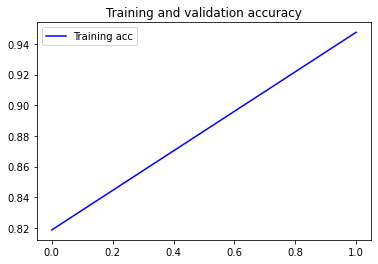

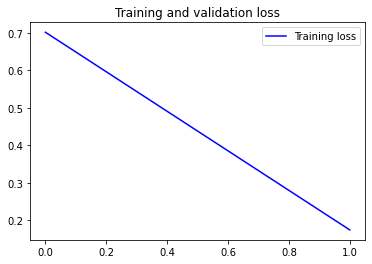

In [10]:
# Utility function for plotting of the model results
def visualize_results(history):
    # Plot the accuracy and loss curves
    acc = history.history['acc']
    #val_acc = history.history['val_acc']
    loss = history.history['loss']
    #val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    #plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    #plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()


# Run the function to illustrate accuracy and loss
visualize_results(history)

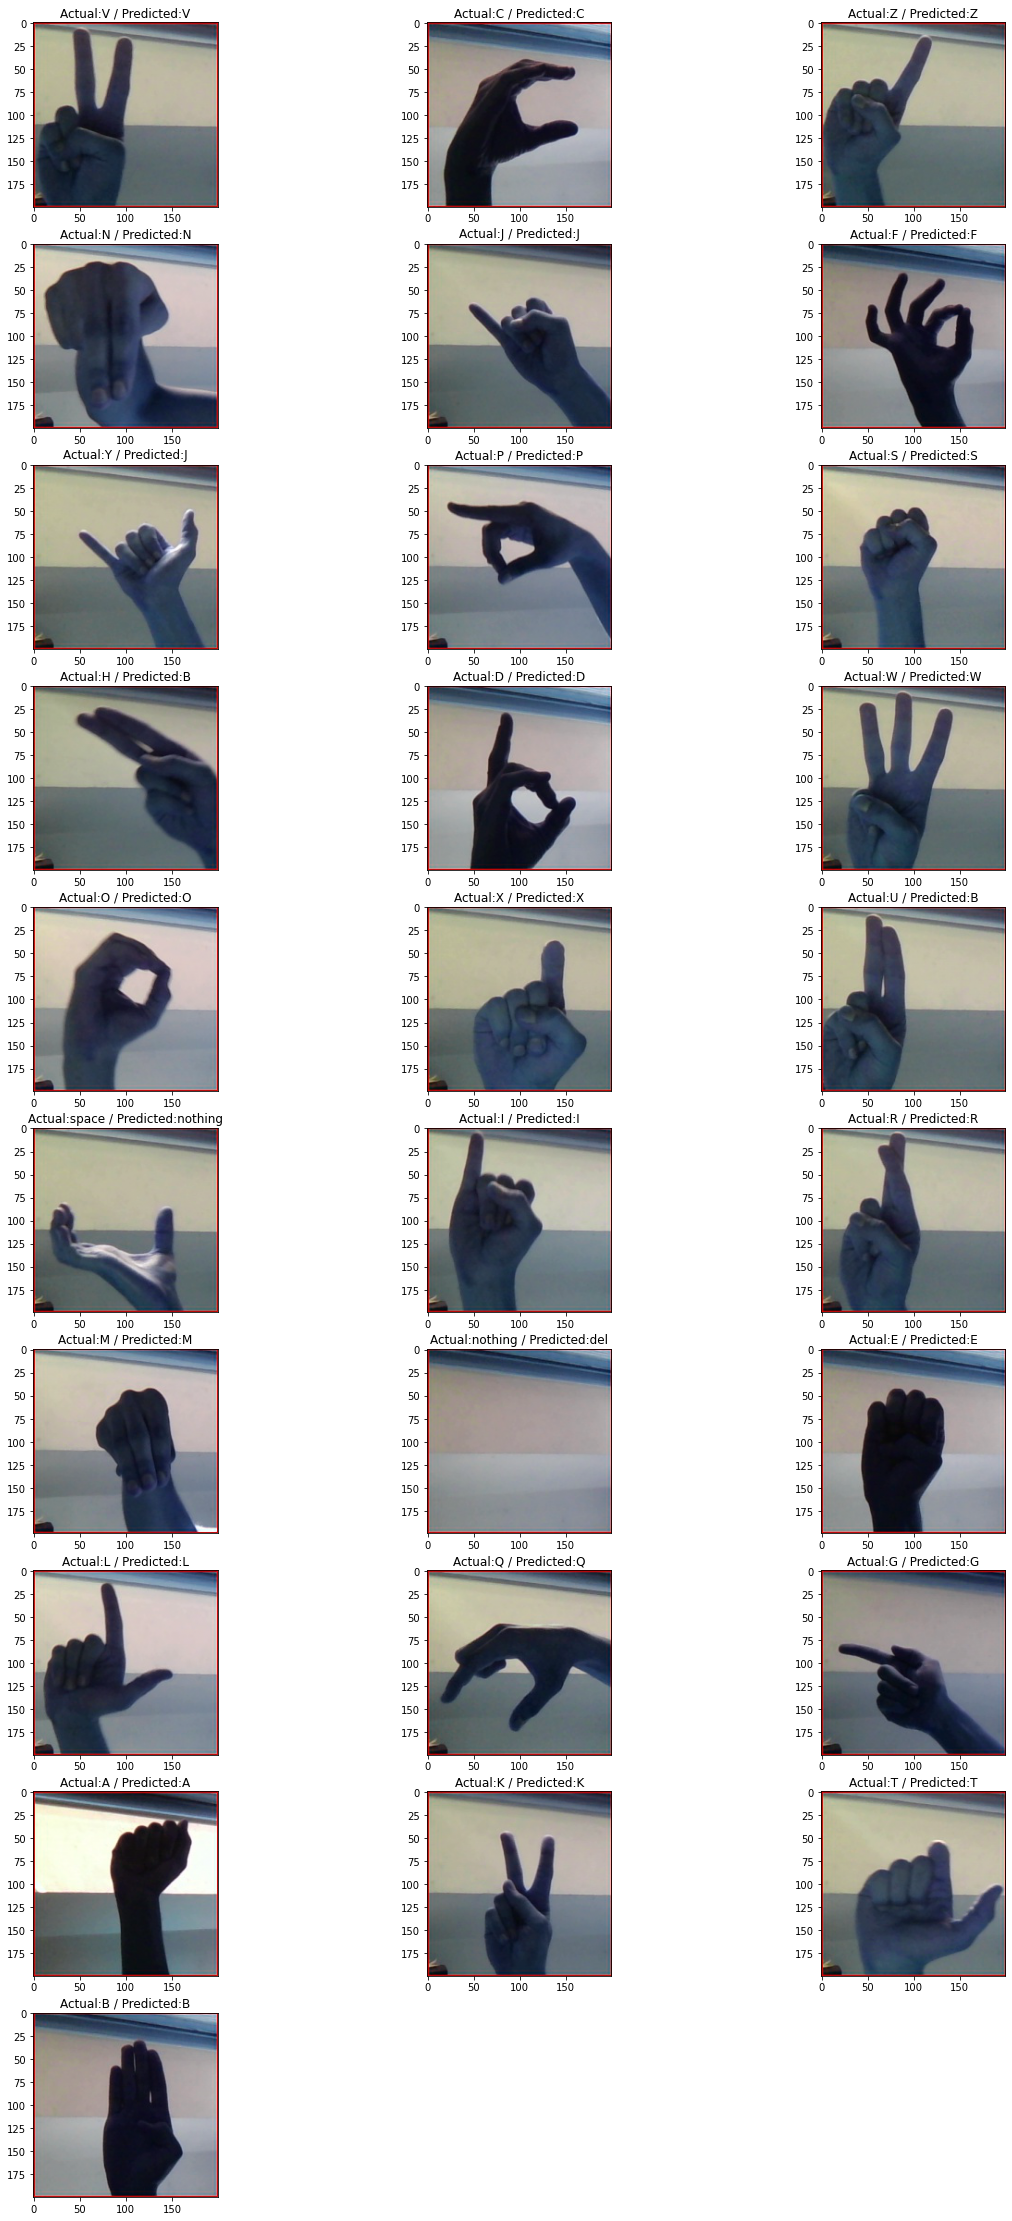

In [12]:
from PIL import Image

labels_dict = {'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'J':9,'K':10,'L':11,'M':12,
                   'N':13,'O':14,'P':15,'Q':16,'R':17,'S':18,'T':19,'U':20,'V':21,'W':22,'X':23,'Y':24,
                   'Z':25,'space':26,'del':27,'nothing':28}

inv_labels_dict = {v: k for k, v in labels_dict.items()}

size_img = 64,64            
plt.figure(figsize=(20,40))
for i in enumerate(os.listdir(test_dir)):
    image = cv2.imread(test_dir+'/'+i[1])
    image = np.asarray(image)
    image = image/255
    #image = cv2.resize(image, size_img)
    
    plt.subplot(10,3,i[0]+1)
    plt.imshow(image)
    pred = np.argmax(model.predict(image.reshape(-1,200,200,3)))
    #print(pred, i[1])
    prediction = -1
    for j in range(29):
        if inv_labels_dict[pred] == inv_labels_dict[j]:
            prediction=inv_labels_dict[pred]
        else:
            continue       
    plt.title('Actual:{0} / Predicted:{1}'.format(i[1].split('_')[0],prediction))
    
plt.show()    
    #pred = np.argmax(model.predict(image.reshape(-1,200,200,3)))
    #for j in train.class_indices:
    #    if pred == train.class_indices[j]:
    #        prediction=j
    #    else:
    #        continue
    
    #plt.title('Actual:{0} / Predicted:{1}'.format(i[1],prediction))